# Medical Dictations: Natural Language Understanding

This script 
- applies IBM Watson Natural Language Understanding on the medical dictations that form the corpus for speech recognition.
- builds a graph of edges between attributes (from Watson NLU) and dictation instances
- identifies topics/archetypes through probabilistic topic modeling
- explores how the archetypal analysis can be used to improve the speech recognition dictation app 

## Part 1:  Imports and Hyperparameters

In [1]:
#++++++++++++++++++++++++++++++++++++++++++++++
# Before running the script, edit 
# 'SET HYPERPARAMETERS' 
# - the rest is automated
#++++++++++++++++++++++++++++++++++++++++++++++

##################
### IMPORT MODULES
##################

### System
import sys
import os

### I/O
import json
import pickle

### General Processing
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import math
import collections

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

### NLU
from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions

### Presentation
from matplotlib import pyplot as plt
import seaborn as sns

## GENERAL FUNCTIONS 
### NORMALIZATION
#### Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

#### Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes a vector - dot product: v @ v = 1
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

#### Algebraic normalization - dot product
def norm_sum(vec, weights = False):
    '''
    Normalizes a vector - sum: v.sum = 1
    '''
    if weights:
        return  vec.sum()
    
    return vec / vec.sum()

#### Scaled Normalization -
def scale(vec, weights = False):
    '''
    Normalizes a vector: v.min = 0, v.max = 1
    '''
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)
def cleanup_chars(string,char_list = ('\n',' ')):
    result = string
    for char in char_list:
        result = result.replace(char,'')
    return result

##########################################
### IBM-WATSON/NLU API-KEY (DON'T EDIT)
##########################################
# The script asks for the API key when run. 
# Do NOT save API-Keys in the code. 

local_dir_exists = os.path.exists('.local')
if not local_dir_exists:
    os.mkdir('.local')
    
credentials_exists = os.path.exists('.local/crd.env')
if not credentials_exists:
    print('Credentials needed for https://cloud.ibm.com/catalog/services/natural-language-understanding )')
    apikey = input(prompt='API-Key?')
    apiurl = input(prompt='API-URL?')
    crd = open('.local/crd.env','w')
    crd.write(  'NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY='+apikey)
    crd.write('\nNATURAL_LANGUAGE_UNDERSTANDING_URL='       +apiurl)  
    

# dian_pkl_file = PATH['results']+'all_dictations_nlu.pkl'  
# dian_pkl_exists = os.path.exists(dian_pkl_file)
# if 'apikey' not in locals():
#     apikey = input(prompt='API-Key? ( https://cloud.ibm.com/catalog/services/natural-language-understanding )')  


# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity


class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    def __init__(self,X,n,norm = norm_dot):
        self.n = n
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(self.X)
        self.o = pd.DataFrame(self.w,index=self.X.index)
        self.on = self.o.T.apply(norm).T
        self.occ = self.on.copy()
        self.occ['Occupations'] = self.occ.index
#        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
        self.occ = self.occ.set_index('Occupations')
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn =self.f.T.apply(norm).T
        self.plot_occupations_dic ={}
        self.plot_features_dic ={}

        
    def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False): 
        '''
        Plot Archetypes as x and features as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters features and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        param = (fig_scale,metric,method,vertical)
        if param in self.plot_features_dic.keys():
            fig = self.plot_features_dic[param]
            return fig.fig

        df = np.square(self.fn)

        if vertical:
            fig = sns.clustermap(df.T,robust = True, z_score=1,figsize=(
                self.n/fig_scale[0],self.X.shape[1]/fig_scale[1]),method = method,metric = metric)        
        else: # horizontal
            fig = sns.clustermap(df,robust = True, z_score=0,figsize=(
                self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)        
        self.features_plot = fig
        return fig


    def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False):
        '''
        Plot Archetypes as x and occupations as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters occupations and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        param = (fig_scale,metric,method,vertical)
        if param in self.plot_occupations_dic.keys():
            fig = self.plot_occupations_dic[param]
            #return
            return fig.fig

        df = np.square(self.occ)
        if vertical:
            fig = sns.clustermap(df, figsize=(
                self.n/fig_scale[0],self.X.shape[0]/fig_scale[1]),method = method,metric = metric)
        else: # horizontal
            fig = sns.clustermap(df.T, figsize=(
                self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)
        self.plot_occupations_dic[param] = fig
        #return
        return fig.fig


class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
        my_svd.volume(keep_volume) 
                        - collections.namedtuple ('dotted dicionary'): 
                          Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
    def volume(self,keep_volume):
        ''' 
        Dimensionality reduction, keeps 'keep_volume' proportion of original variance
        Type: collections.namedtuple ('dotted dictionary')
        Examples of usage:
        my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
        my_svd.volume(0.8).f - dataframe: features for 80% variance
        my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
        '''
        dotted_dic = collections.namedtuple('dotted_dic', 's f o')
        a1 = self.s.cumsum()
        a2 = a1/a1[-1]
        n_max = np.argmin(np.square(a2 - keep_volume))
        cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
        return cut_dic
        


##########################
## SET HYPERPARAMATERS
#### edit below ##########

# Import credentials
cred = open('.local/crd.env','r').read()
apikey,apiurl = cred.replace('NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY=','').replace(
                            'NATURAL_LANGUAGE_UNDERSTANDING_URL=','').split()

PATH = {}
PATH['data']    = '../data/Documents/'
PATH['results'] = './Watson-nlu-results/'

NLU = {}
NLU['apikey']         = apikey
NLU['apiurl']         = apiurl
NLU['version']        = '2019-07-12'
NLU['features']       = Features(
                        categories= CategoriesOptions(limit=4),
                        concepts  = ConceptsOptions(limit=20),
                        entities  = EntitiesOptions(limit=20),
                        keywords  = KeywordsOptions(limit=20),
                        relations = RelationsOptions(),
                        syntax    = SyntaxOptions()
                        )

nlu = NaLaUn(version=NLU['version'] , iam_apikey = NLU['apikey'], url = NLU['apiurl'])  #Local Natural Language Understanding object

## Part 2:  Data Preparation

In [3]:
################
## PREPARE DATA 
################
filenames = os.listdir(PATH['data']) 
dictation_dic = {}            #dictionary for dictation files
for name in filenames:
    dictation_dic[name.replace('.txt','')] = open(PATH['data']+name).read()

    
# Treat dictations_dic as 
# - dict when type(key)=str, eg dictation_dic['12'] -> value for key '12'
# - list when type(key)=int, eg dictation_dic[12] -> 12th value in dictionary 
def select_dictation(key):
    if type(key) is int:
        aa = list(dictation_dic.values())[key]
    else:
        aa = dictation_dic[key]
    return aa
dn = select_dictation           # dn <- Short name for select_dictation

## Part 3: Perform Watson NLU analysis

Imports analysis if it already exists, else:

- Analyzes each dictation text file
- Saves each analysis as a pickled file
- Keeps all analyzed file objects in a dictionary "dictation_analysis"
- Saves the dictionary as a pickled file "all_dictations_nlu.pkl"

In [4]:
###############################
## PERFORM WATSON NLU ANALYSIS
###############################
dictation_analysis = {}
dian = dictation_analysis

# If dictation_analysis dictionary already exists - read the pickled file
# If it does NOT already exist, perform calculations. 
dian_pkl_file = PATH['results']+'all_dictations_nlu.pkl'  
dian_pkl_exists = os.path.exists(dian_pkl_file)

if dian_pkl_exists:
    dian = pickle.load( open( dian_pkl_file, "rb" ) )

else: #perform nlu-analysis on dictations
    for item in list(dictation_dic.items()):
        lbl  = item[0]
        text = item[1]
        dian[lbl] = nlu.analyze(text = text, features=NLU['features'])
        f = open(PATH['results']+str(lbl)+'_nlu.pkl','wb')
        pickle.dump(dian[lbl],f)
        f.close()

    f = open(dian_pkl_file,'wb')
    pickle.dump(dian,f)
    f.close()  

# Transform dian to Pandas Dataframes
df_dic = {}
for dctn in dian.items():
    df_dic[dctn[0]] = {}
    for item in list(dctn[1].result.items()):
        df_dic[dctn[0]][item[0]]=pd.DataFrame(list(item[1]))

## Part 4: Archetypal Analysis
- Soft cluster dictations and attributes (from Watson NLU). Method: NMF 

In [5]:
df = pd.DataFrame()

for key in df_dic:
    dfx = df_dic[key]['concepts'].copy()
    dfx['dictation'] = key
    df = df.append(dfx,sort=True)

mat = df.pivot('dictation','text','relevance')
m = mat.fillna(0)

archetypes = {}

In [6]:
n = 10 # Select number of Archetypes
mar = Archetypes(m,n)
archetypes[n] = {}
for i in range(n):
    archetypes[n][i] = mar.f.iloc[i].sort_values(ascending=False)[:20]
    print(str(i+1)+' of '+str(n))
    print(archetypes[n][i])
    print('\n')

1 of 10
text
Hypertension             2.550315
Cardiology               2.210293
Medical history          1.653104
Myocardial infarction    1.584359
Heart failure            1.374980
Blood                    1.147652
Blood pressure           1.142514
Medicine                 0.724154
Anemia                   0.547630
Shortness of breath      0.319499
Asthma                   0.305739
Potassium                0.297487
Medical record           0.239589
Obesity                  0.235995
Pulse                    0.224551
Samuel Anders            0.209738
Physical examination     0.200093
Hemoglobin               0.195949
Tachycardia              0.186058
Bradycardia              0.172906
Name: 0, dtype: float64


2 of 10
text
Atrial fibrillation                3.170790
Stroke                             2.905939
Heart                              2.482180
Jugular venous pressure            1.017858
Pulmonary embolism                 0.849939
Blood                              0.683432
Warf

# Sandbox. Ignore - not part of the code

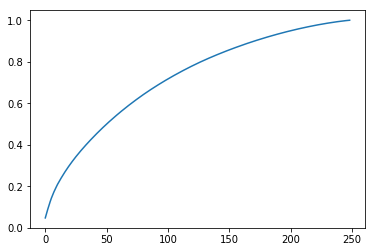

In [258]:
# Singular Value Decomposition
msv = Svd(m)
s = msv.s.cumsum()
plt.plot(s/s[-1])

In [27]:
aaa = dian['3']

In [39]:
pd.DataFrame.from_dict(aaa.result['keywords'])

,count,relevance,text
0,1,0.632321,History of present illness
1,1,0.620887,oropharyngeal dysphagia
2,3,0.584741,end-stage
3,2,0.569271,62-year-old male
4,1,0.569141,physical exam
5,1,0.567809,Family history
6,1,0.566610,ferrous sulfate
7,1,0.563624,outside hospital
8,1,0.563095,nasogastric tube feeds
9,15,0.562367,patient


In [21]:
pd.DataFrame.from_dict(aaa.result['concepts'])

AttributeError: 'Features' object has no attribute 'result'

In [40]:
pd.DataFrame.from_dict(aaa.result['categories'])

,label,score
0,/health and fitness/disease,0.972914
1,/health and fitness/therapy,0.847317
2,/health and fitness/weight loss,0.841645
3,/health and fitness/disorders,0.795234


In [37]:
pd.DataFrame.from_dict(aaa.result['entities'])

,confidence,count,disambiguation,relevance,text,type
0,0.908503,3,NaN,0.952760,stage renal disease,HealthCondition
1,0.960000,2,NaN,0.765695,62-year,Quantity
2,0.999991,3,"{'subtype': ['DiseaseOrMedicalCondition', 'Cau...",0.648505,cirrhosis,HealthCondition
3,0.276687,1,NaN,0.495814,hypercapnic respiratory failure,HealthCondition
4,0.665347,1,"{'subtype': ['DiseaseOrMedicalCondition', 'Dis...",0.483777,pancytopenia,HealthCondition
5,0.529816,1,NaN,0.458535,gastrointestinal malignancy,HealthCondition
6,0.800000,1,NaN,0.384852,100%,Quantity
7,0.800000,1,NaN,0.383476,3 liters,Quantity
8,0.619878,1,NaN,0.372212,HEENT,Person
9,0.457756,1,NaN,0.351234,JVD,Person


In [41]:
pd.DataFrame.from_dict(aaa.result['relations'])

,arguments,score,sentence,type
0,"[{'text': 'He', 'location': [163, 165], 'entit...",0.849376,He was admitted to outside hospital for worsen...,agentOf
1,"[{'text': 'Midodrine', 'location': [1378, 1387...",0.536084,"Medications, Procrit, Effexor, Lipitor, depake...",locatedAt
2,"[{'text': 'Atarax', 'location': [1389, 1395], ...",0.909557,"Medications, Procrit, Effexor, Lipitor, depake...",locatedAt
3,"[{'text': 'Patient', 'location': [1469, 1476],...",0.978107,Patient denies any fevers or chills.,agentOf
4,"[{'text': 'patient', 'location': [1594, 1601],...",0.464201,"On physical exam, patient has a blood pressure...",hasAttribute
5,"[{'text': 'hemoglobin', 'location': [2447, 245...",0.397797,"Laboratory, patient has white count of 4.5, he...",locatedAt
6,"[{'text': 'patient', 'location': [2415, 2422],...",0.542752,"Laboratory, patient has white count of 4.5, he...",hasAttribute
7,"[{'text': 'patient', 'location': [2626, 2633],...",0.456632,"Impression, recommendations, patient is a 62-y...",hasAttribute
8,"[{'text': 'patient', 'location': [3946, 3953],...",0.748083,ID is following patient {period} Regarding end...,hasAttribute
9,"[{'text': 'patient', 'location': [3289, 3296],...",0.361502,Presence of ascites would be developing contra...,partOfMany


In [2]:
1+1

2